In [20]:
from utils import load_and_prepare_building_dfs, get_voll_temps, normalize_building_dfs
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
building_dfs = load_and_prepare_building_dfs(esave_path="data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls", vis_path='data/VIS Målere.xlsx')
temp = get_voll_temps(voll_path='data/Volltemp.xlsx')

Data loaded in 89.66173362731934 seconds


In [33]:
building_dfs = normalize_building_dfs(building_dfs, method='min-max')

print(len(building_dfs))
for building_name, building_df in list(building_dfs.items()):
    building_dfs[building_name] = building_df.resample('D').sum()
    if building_df.isnull().values.any():
        print(f'{building_name} has null values')
        building_dfs.pop(building_name)

    elif building_df.isna().values.any():
        print(f'{building_name} has nan values')
        building_dfs.pop(building_name)

print(len(building_dfs))

daily_temp = temp.resample('D').mean()['Eklima_68860_TAM']

172
172


In [92]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, dx, dy):
        self.dx = dx
        self.dy = dy

    def expected(self, temperature):
        if temperature < self.dx[0]:
            # print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            # TODO improve this prediction
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            # print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series, threshold):
        expected_series = self.get_expected_series(temperature_series)
        mask = (energy_series - expected_series).abs() >= threshold * expected_series
        return energy_series[mask]

    def plot(self, energy_series, temperature_series, threshold=None):
        plt.plot(self.dx, self.dy, color='red', linewidth=4)

        # if threshold is given, find anomalies and color them in the scatter plot
        plt.scatter(temperature_series, energy_series, color='blue')
        if threshold is not None:
            anomalies = self.get_anomolies_series(energy_series, temperature_series, threshold)
            plt.scatter(temperature_series[anomalies.index], energy_series[anomalies.index], color='red')
            # plot one curve over and under the expected curve
            sorted_temperature_series = temperature_series.sort_values()
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) * (1 + threshold), color='green', linewidth=6)
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) * (1 - threshold), color='green', linewidth=6)
            
        plt.show()
        
    def get_mse(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return ((energy_series - expected_series) ** 2).mean()

In [10]:
def model_1(energy_consumption_series: pd.Series, temperature_series: pd.Series, points_per_segment, plot: bool = False):
    # ensure that we match values for energy and temp
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points + 1, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = LinearRegression()
        model.fit(X_seg, y_seg)

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])

    return et_curve(dx, dy)

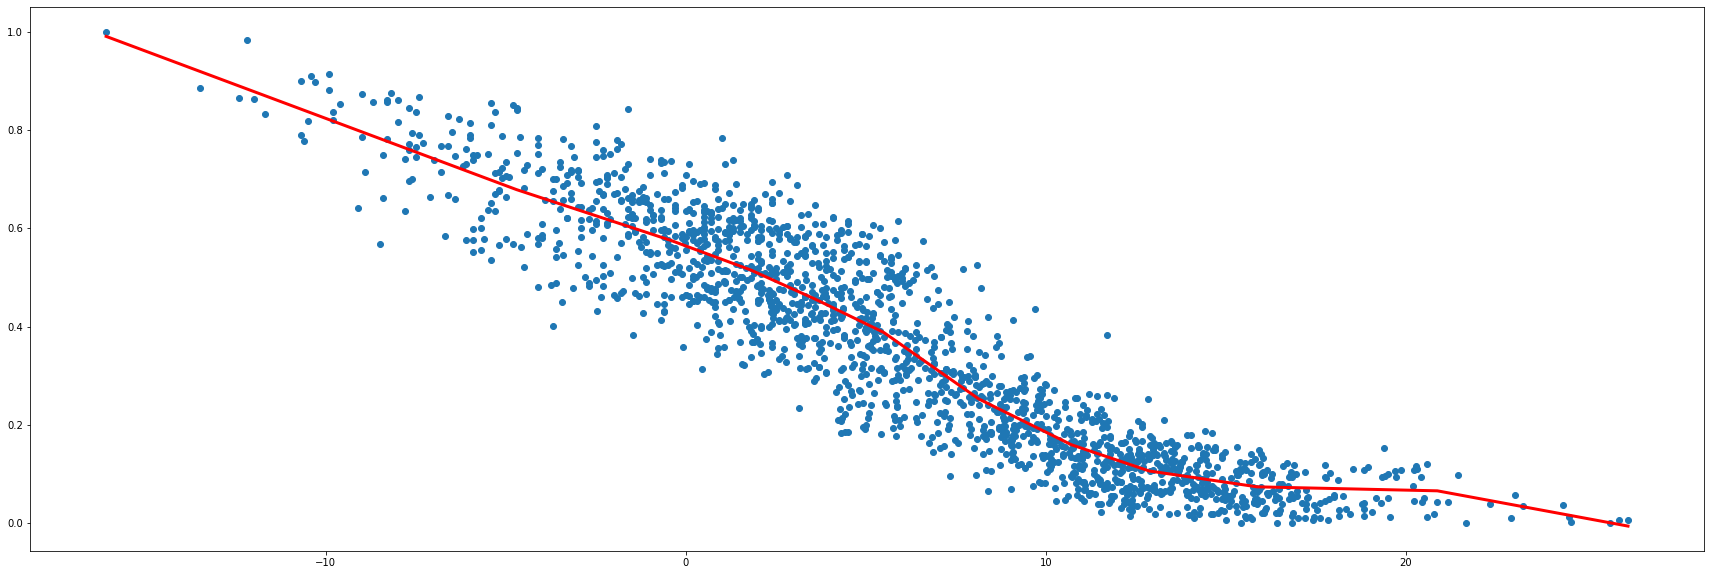

Trondheim Kommune - Angelltrøa barnehage has mse of 0.0068295612467436945


In [34]:
plt.rcParams['figure.figsize'] = (30, 10)
test_building_name = 'Trondheim Kommune - Lilleby skole'
test_energy = building_dfs[test_building_name]['Totalt']

et_1 = model_1(test_energy, daily_temp, 200)
et_1.plot(test_energy, daily_temp)
print(f'{building_name} has mse of {et_1.get_mse(test_energy, daily_temp)}')

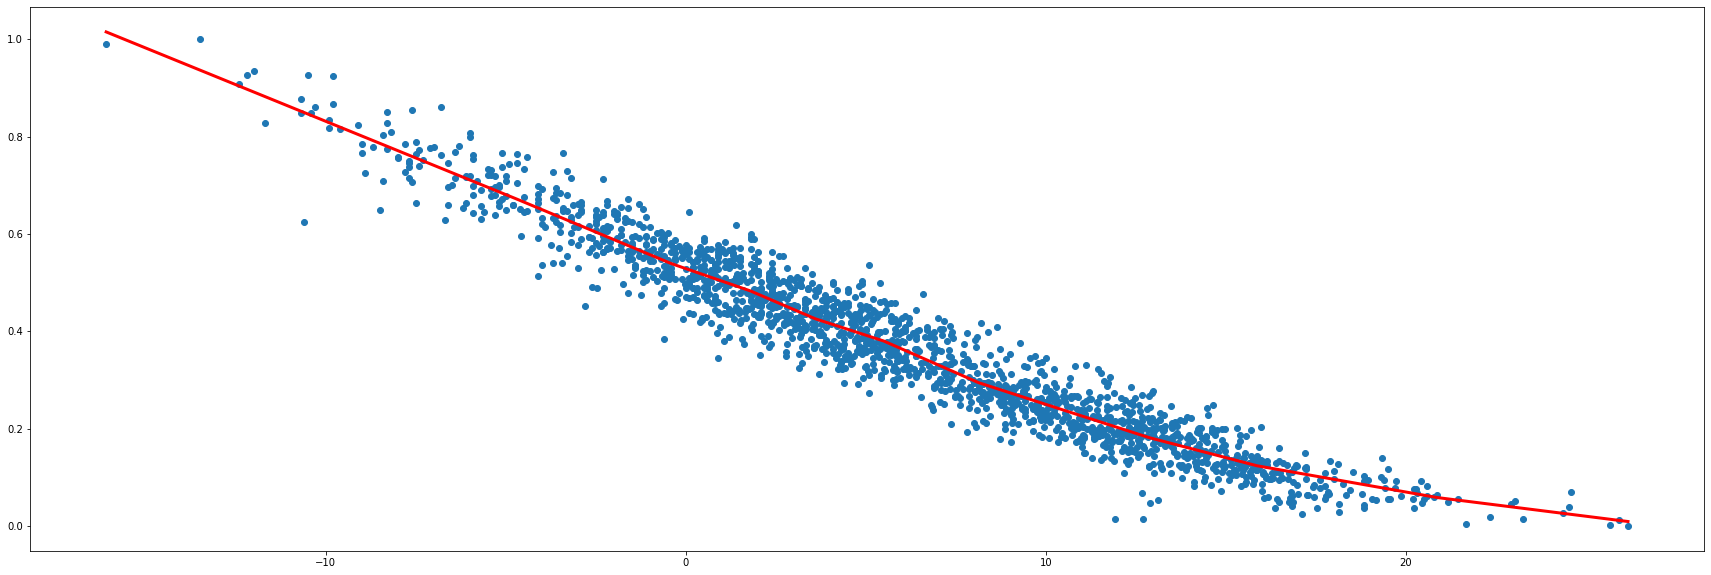

Trondheim Kommune - Charlottenlund helse og velferdssenter has mse of 0.002098001280596112 and is ranked 1 of 172


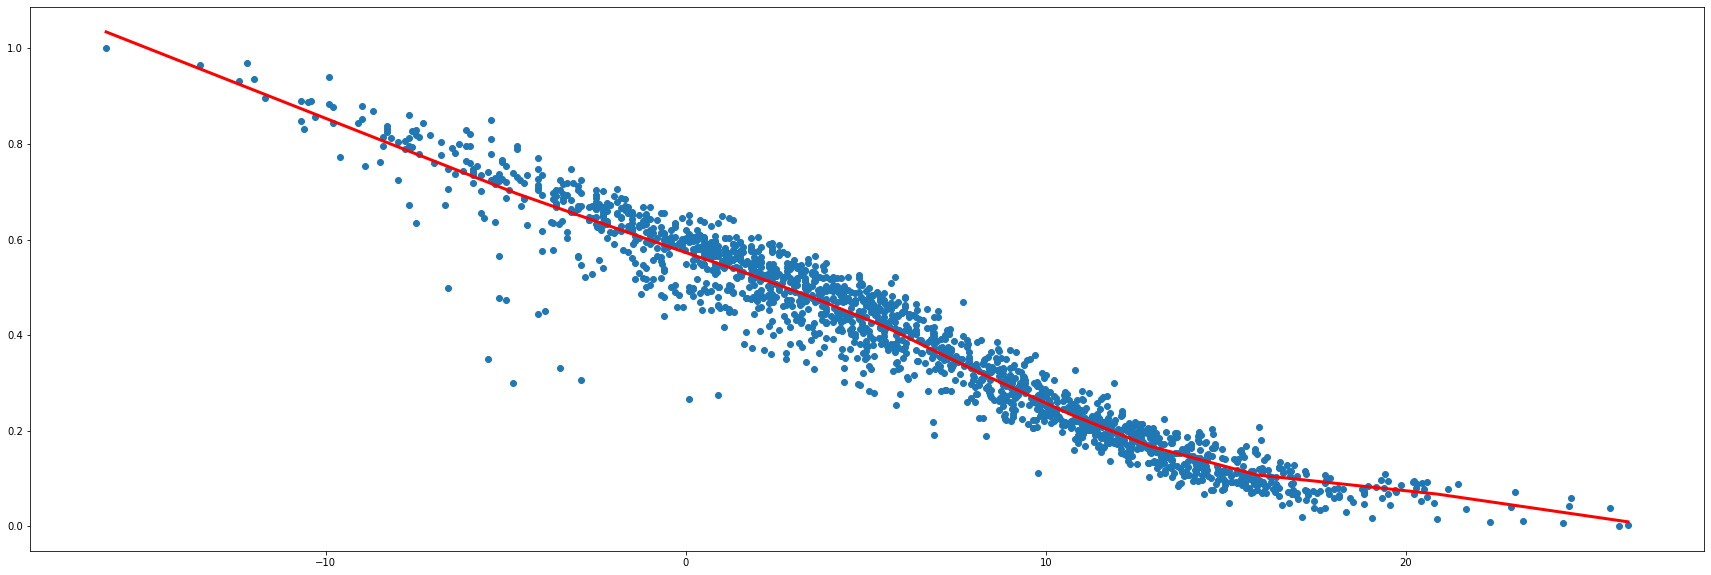

Trondheim Kommune - E C Dahls helse og velferdssenter has mse of 0.002396214654103671 and is ranked 2 of 172


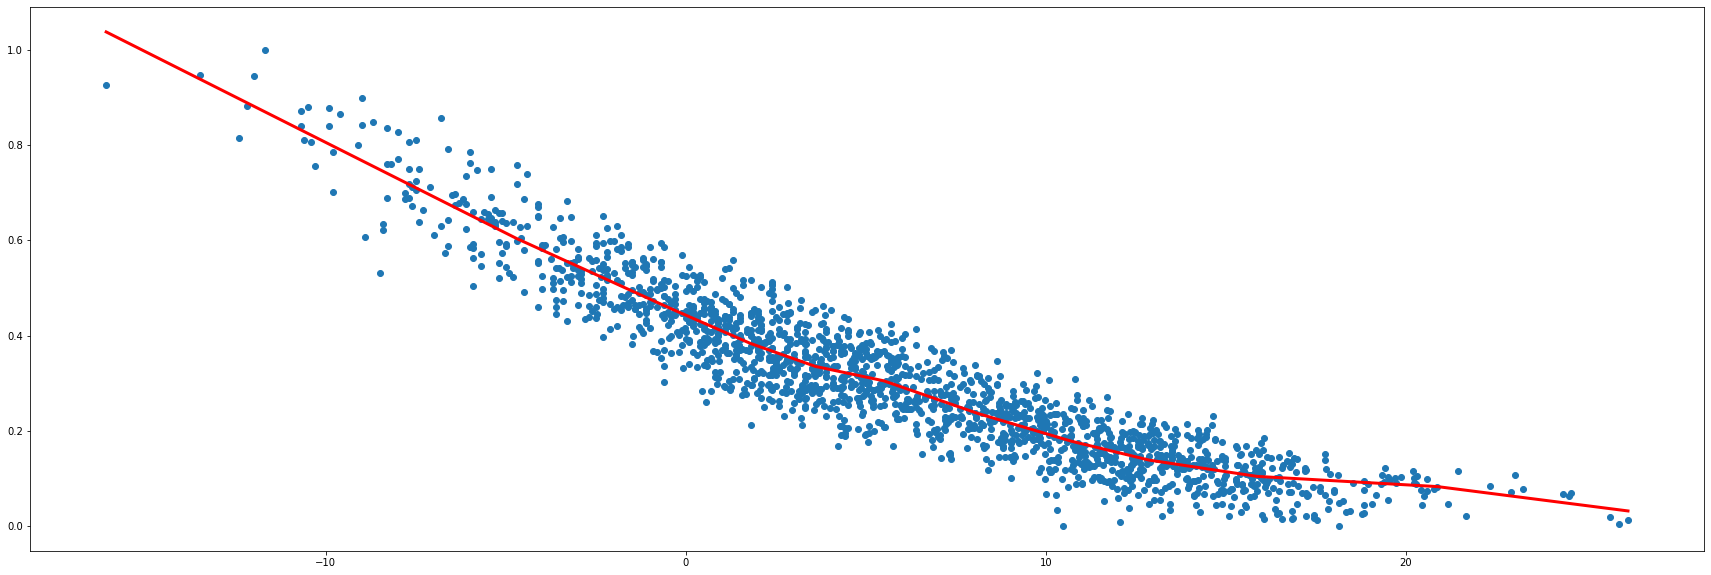

Trondheim Kommune - Valentinlyst helse og velferdssenter has mse of 0.0032008032941837497 and is ranked 3 of 172


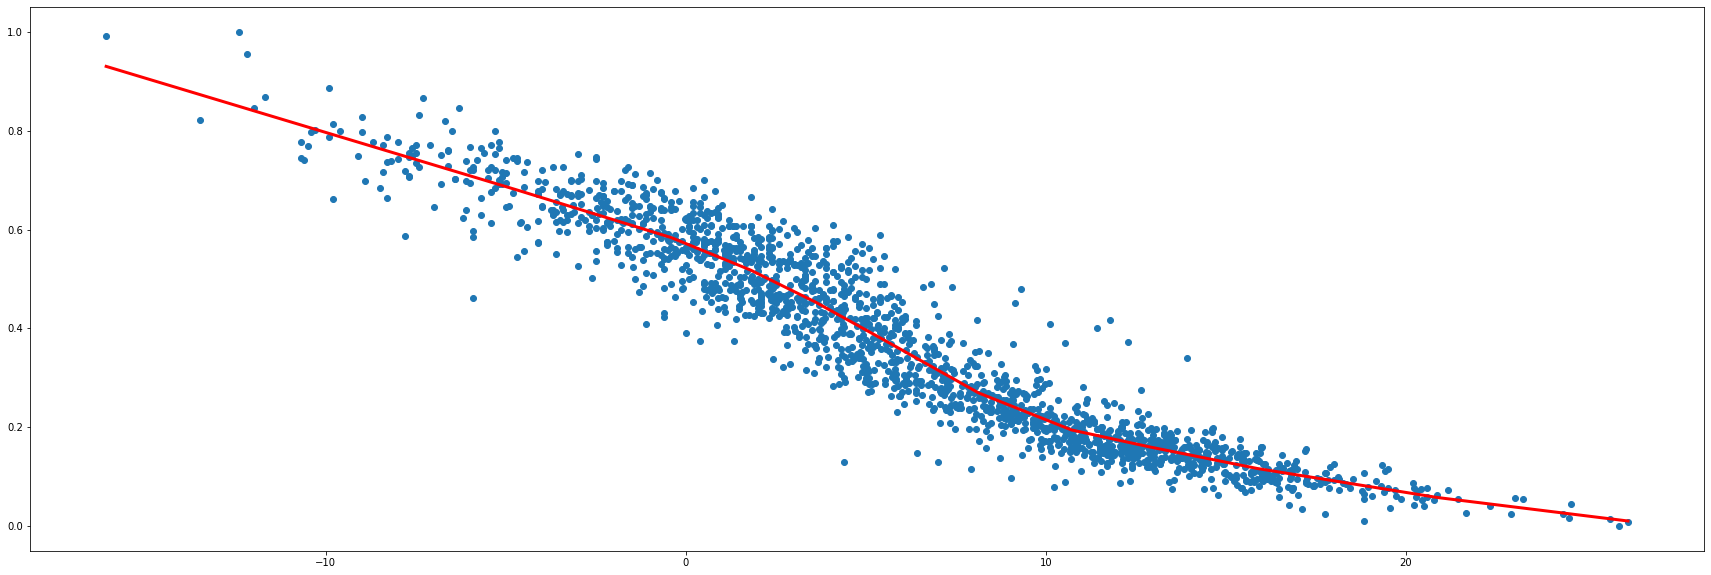

Trondheim Kommune - Moholt helse- og velferdssenter has mse of 0.0032195854845974117 and is ranked 4 of 172


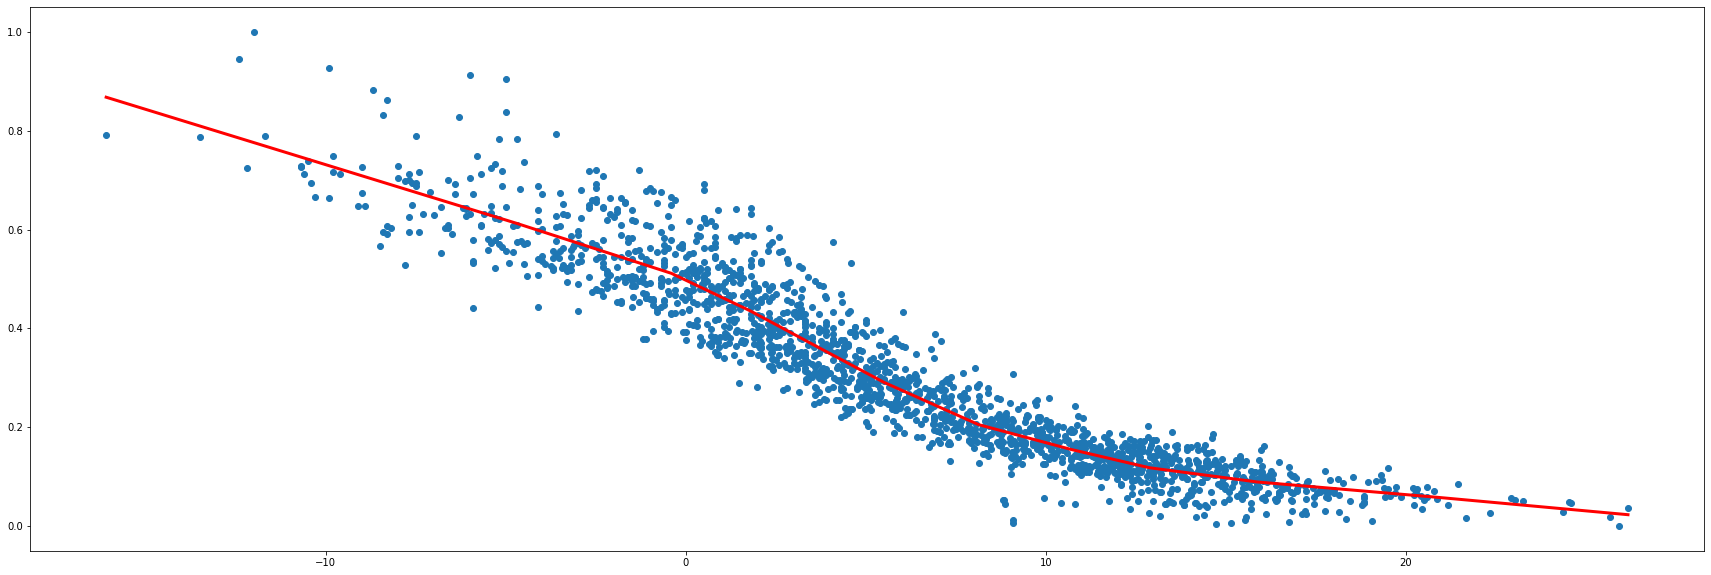

Trondheim Kommune - Kattem helse- og velferdssenter has mse of 0.0033510789530305247 and is ranked 5 of 172


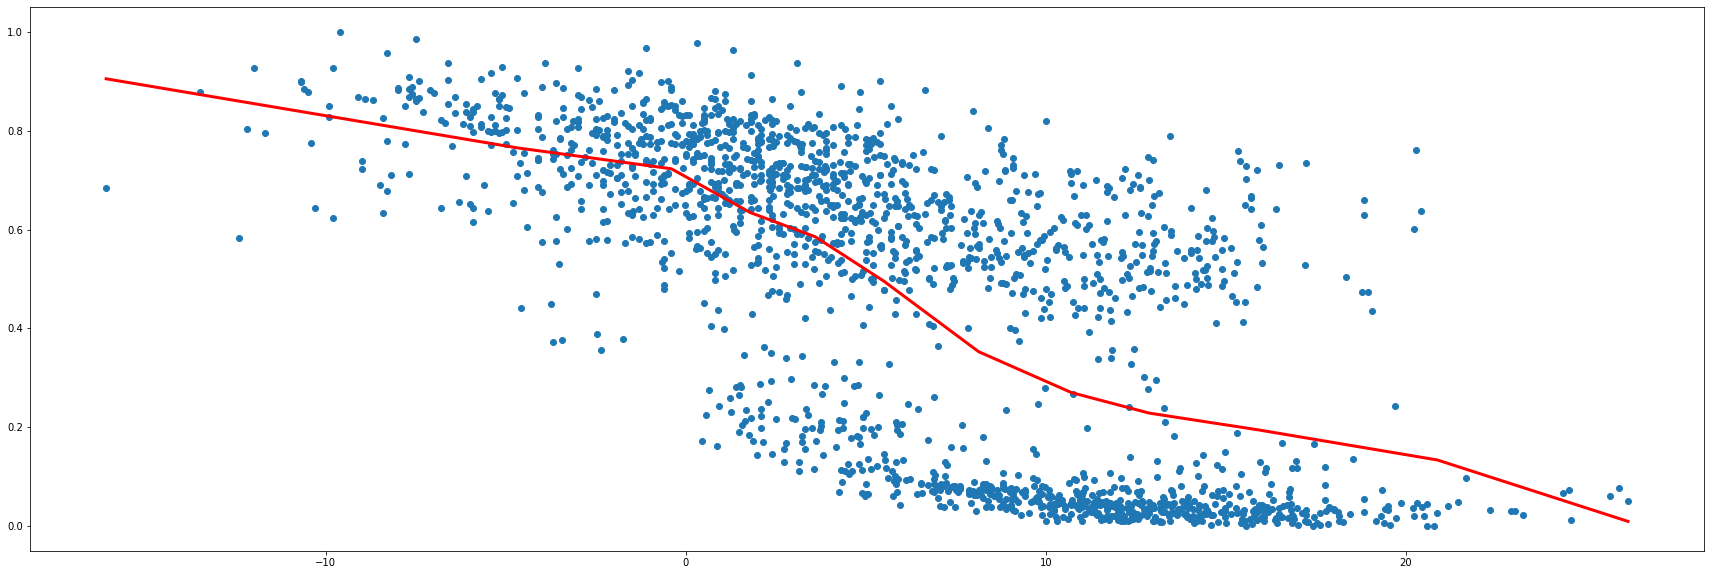

Trondheim Kommune - Dalgård ishall has mse of 0.04663049755609174 and is ranked 172 of 172


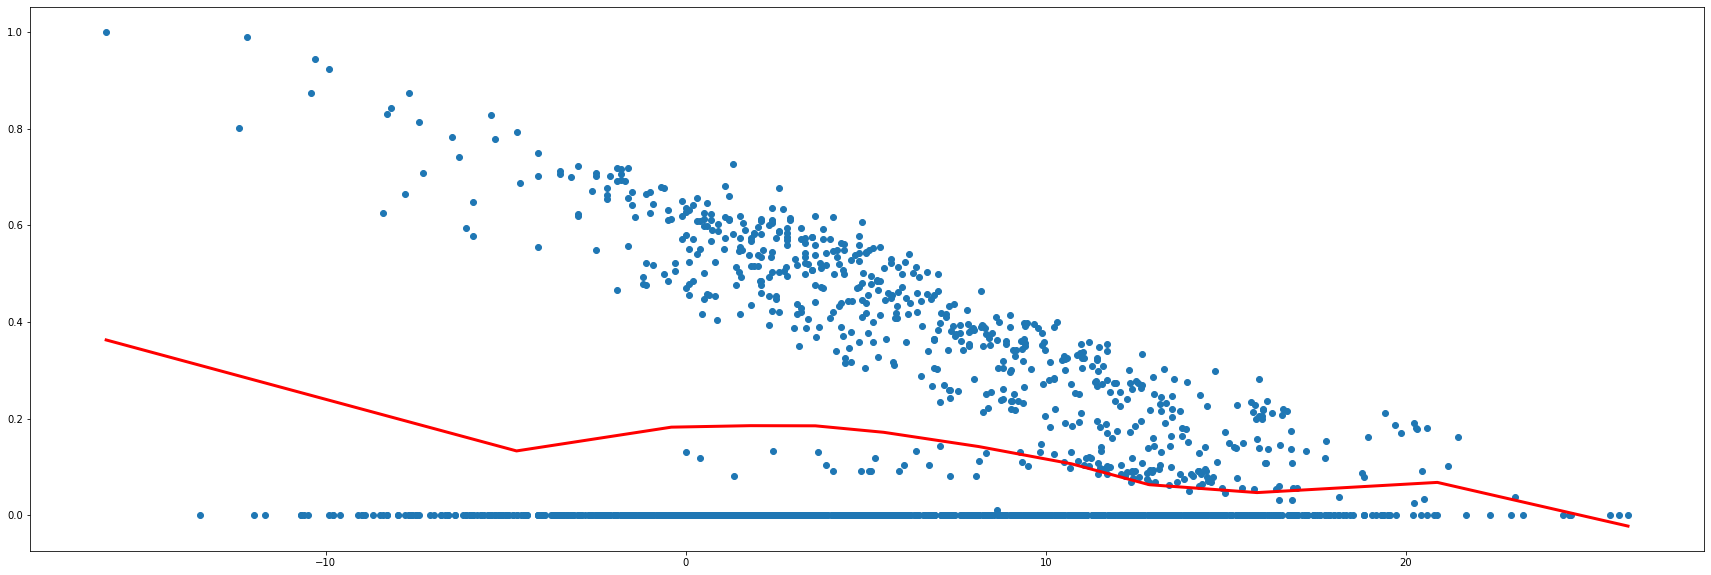

Trondheim Kommune - Smidalen barnehage has mse of 0.044075380190850624 and is ranked 171 of 172


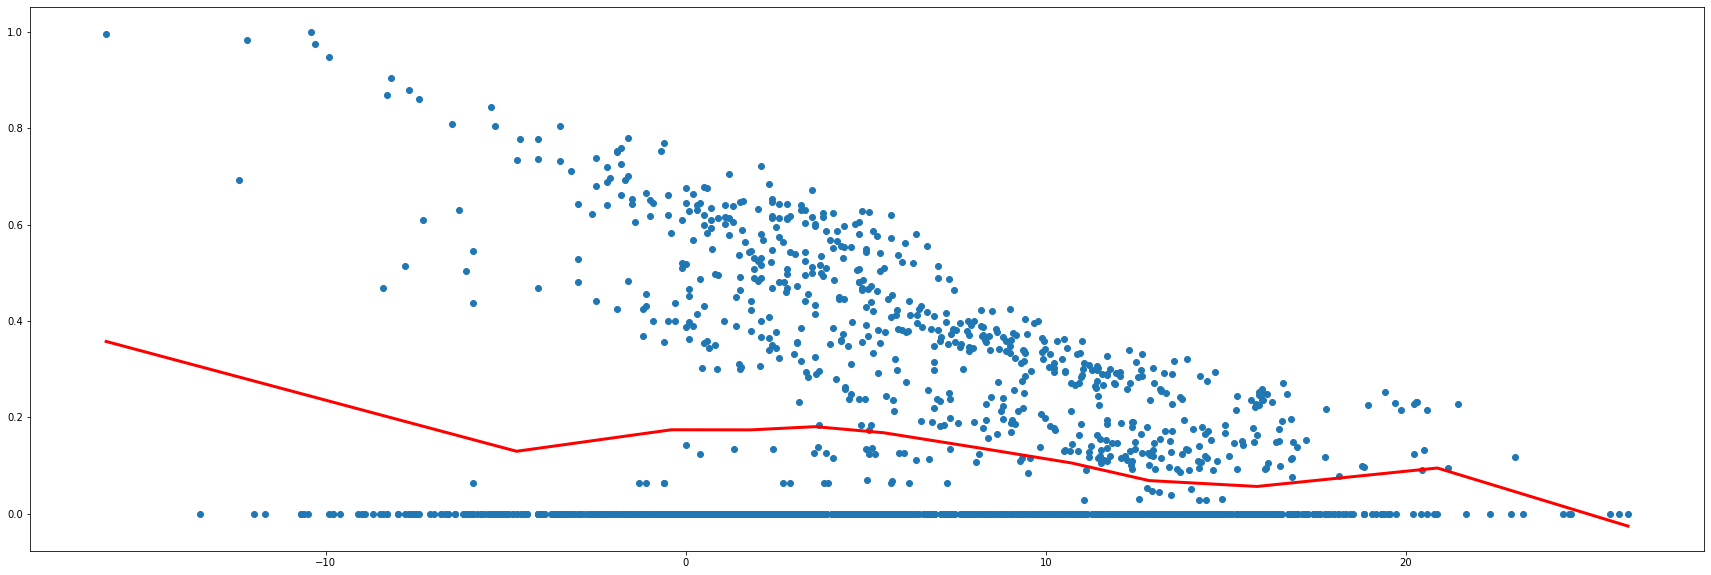

Trondheim Kommune - Hammersborg barnehage has mse of 0.042064232474914975 and is ranked 170 of 172


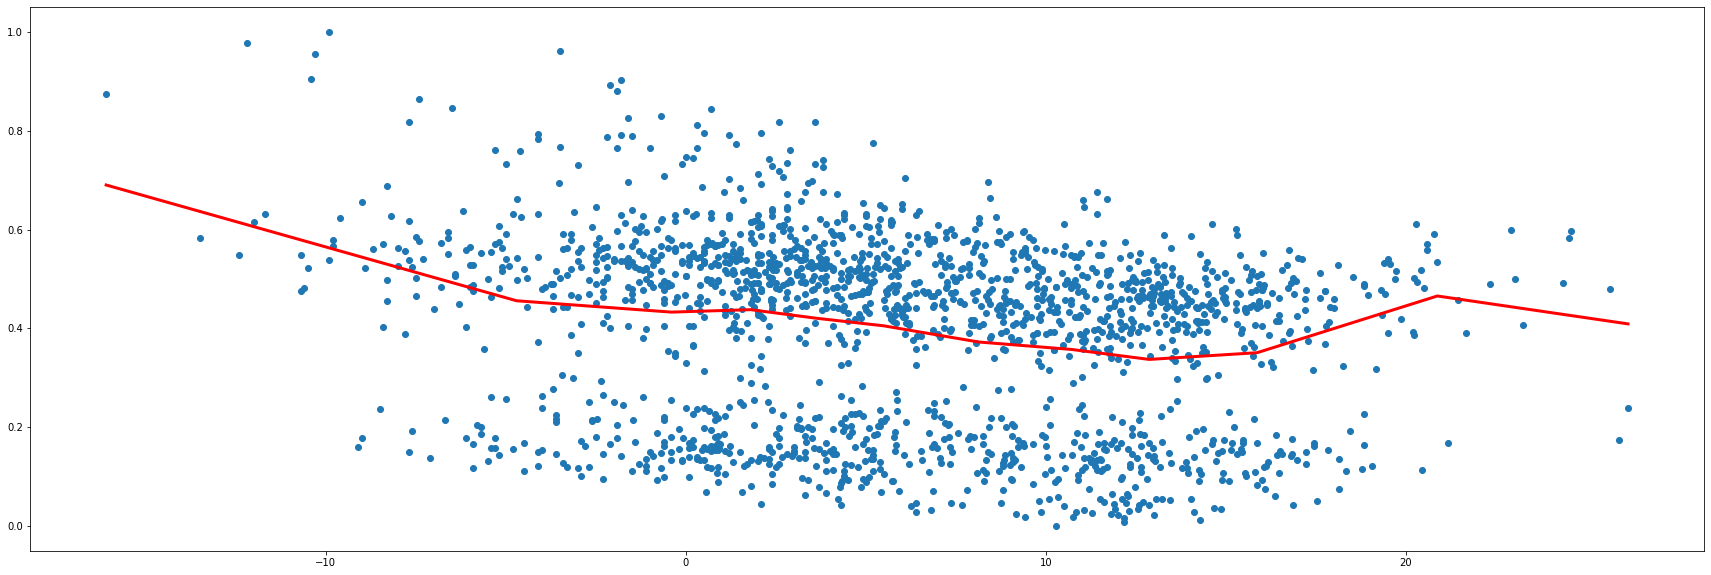

Trondheim Kommune - Produksjonskjøkkenet has mse of 0.031674700046694725 and is ranked 169 of 172


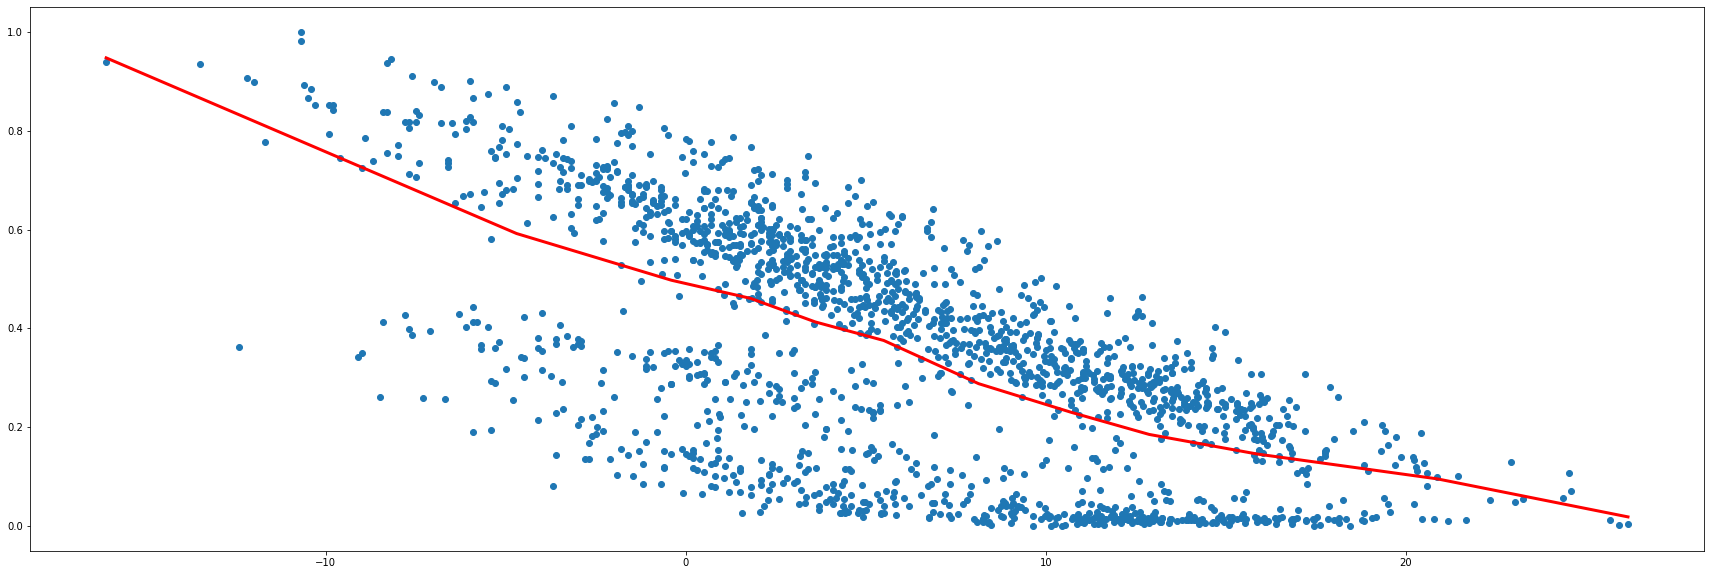

Trondheim Kommune - Korsvika barnehage has mse of 0.030791447924326067 and is ranked 168 of 172


In [35]:
# do the above for all buildings and sort by mse
building_et_results = []
for building_name, building_df in list(building_dfs.items()):
    building_energy = building_df['Totalt']
    et_model = model_1(building_energy, daily_temp, 200)
    et_mse = et_model.get_mse(building_energy, daily_temp)
    building_et_results.append((building_name, et_mse, et_model))

# sort by mse
building_et_results.sort(key=lambda x: x[1])

# plot the top 5
for i in range(5):
    building_name, et_mse, et_model = building_et_results[i]
    building_energy = building_dfs[building_name]['Totalt']
    et_model.plot(building_energy, daily_temp)
    print(f'{building_name} has mse of {et_mse} and is ranked {i+1} of {len(building_et_results)}')

# plot the bottom 5
for i in range(5):
    building_name, et_mse, et_model = building_et_results[-i-1]
    building_energy = building_dfs[building_name]['Totalt']
    et_model.plot(building_energy, daily_temp)
    print(f'{building_name} has mse of {et_mse} and is ranked {len(building_et_results) - i} of {len(building_et_results)}')

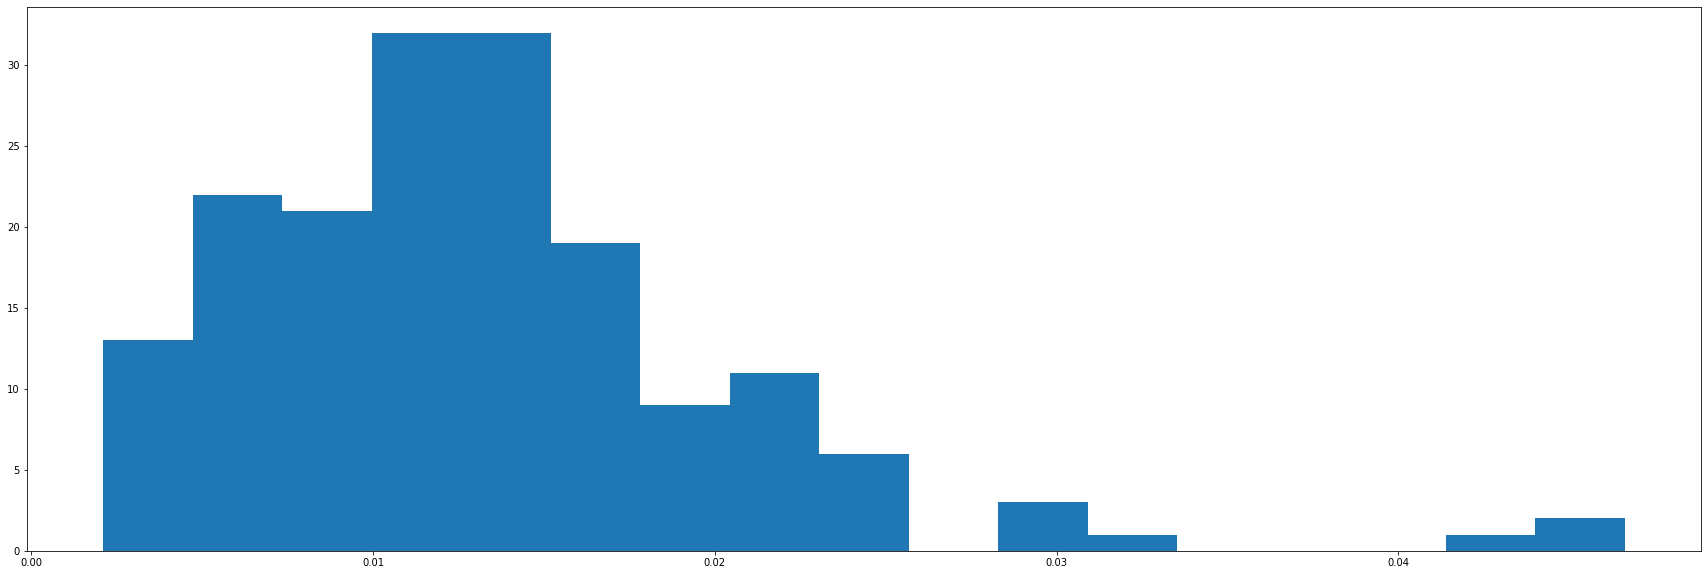

In [36]:
# plot distribution of mses
mse_values = [x[1] for x in building_et_results]
plt.hist(mse_values, bins='auto')
plt.show()

172 buildings before dropping
145 buildings after dropping


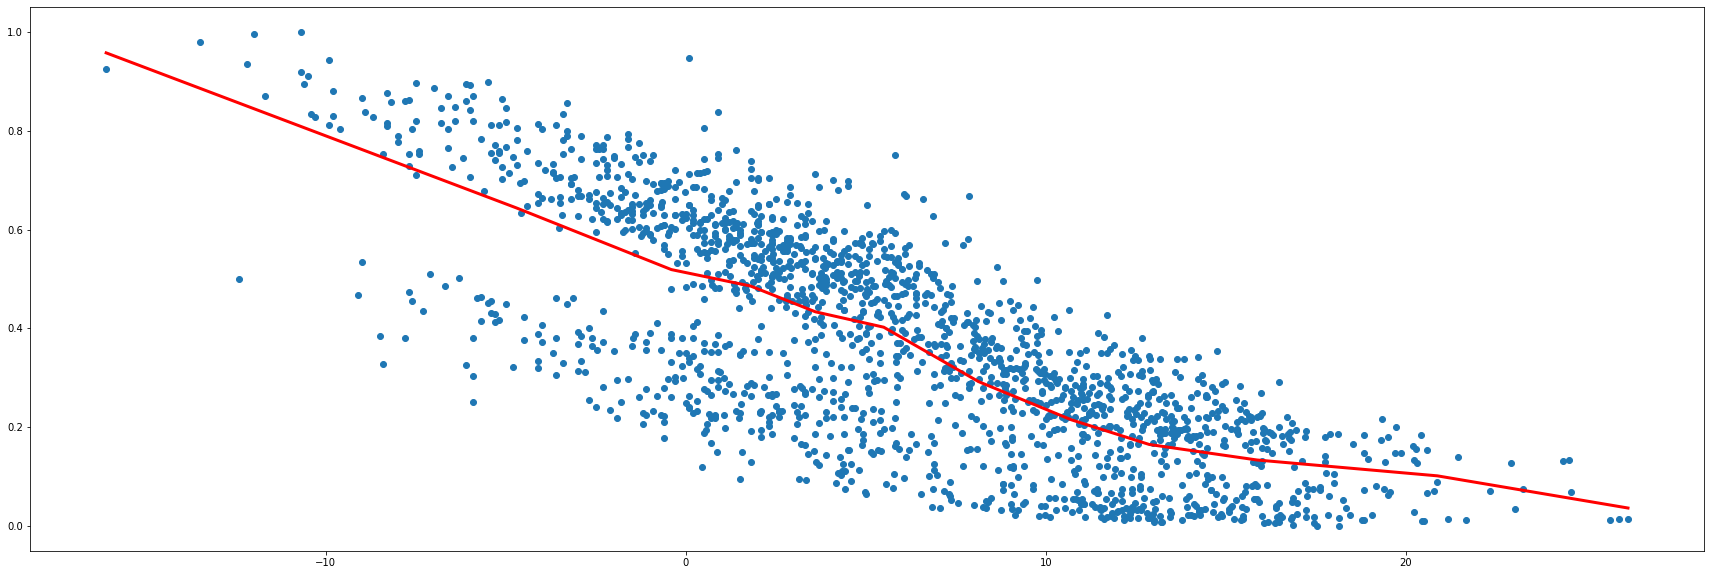

Trondheim Kommune - Kulsås barnehage has mse of 0.01985566977791488 and is ranked 145 of 145


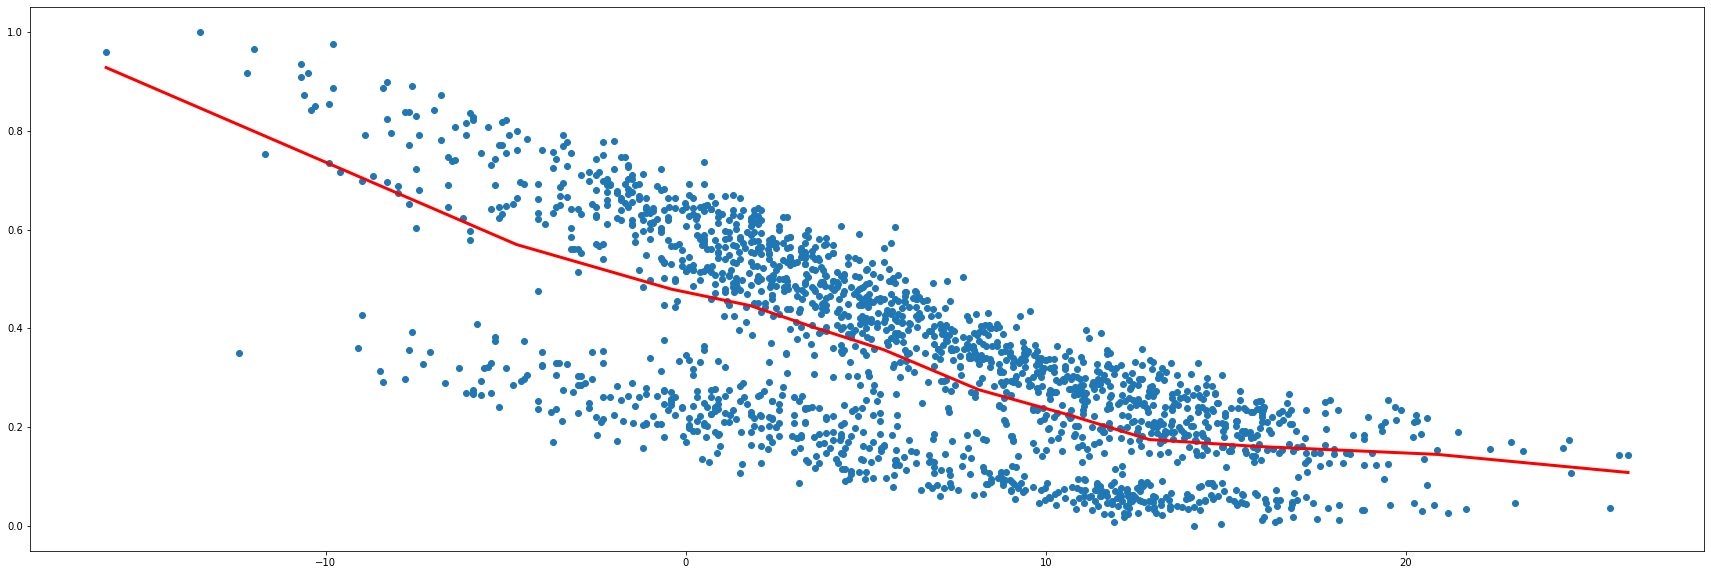

Trondheim Kommune - Grillstadfjæra barnehage has mse of 0.019687245266234523 and is ranked 144 of 145


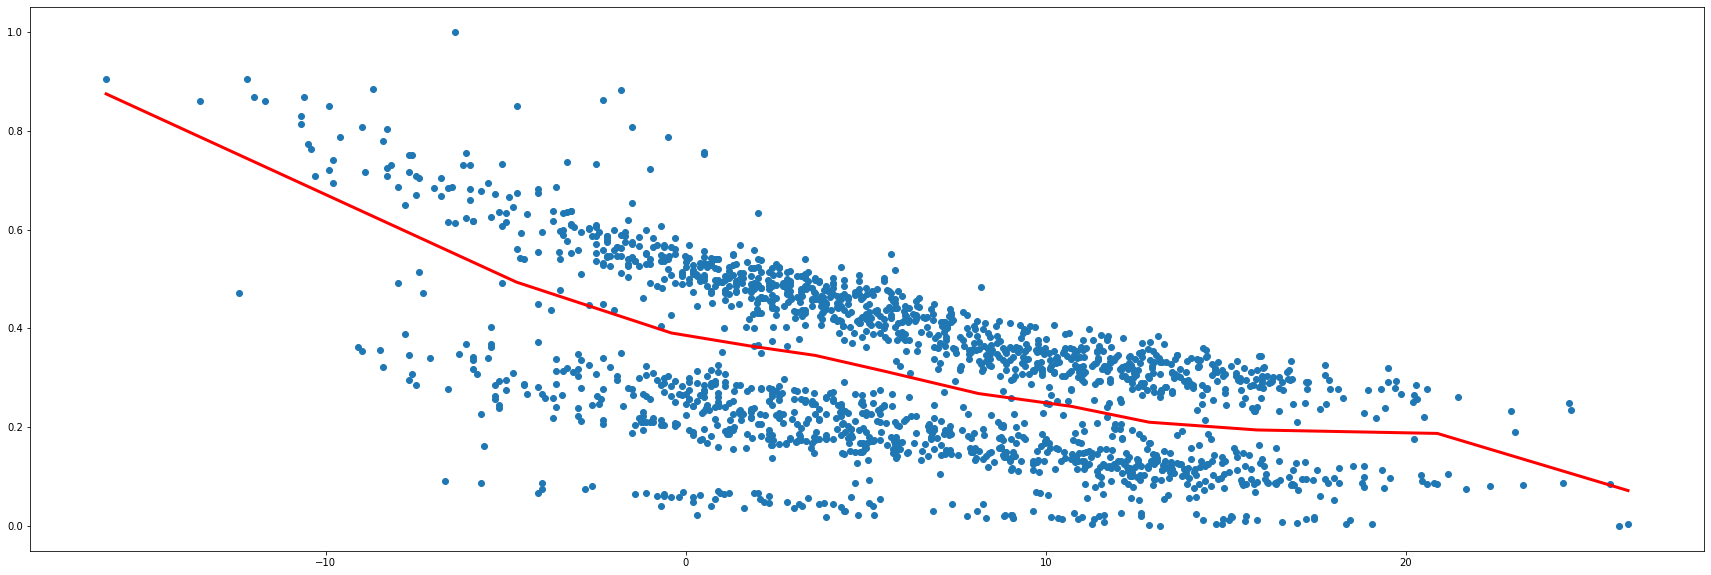

Trondheim Kommune - Iladalen barnehage has mse of 0.019274634835516502 and is ranked 143 of 145


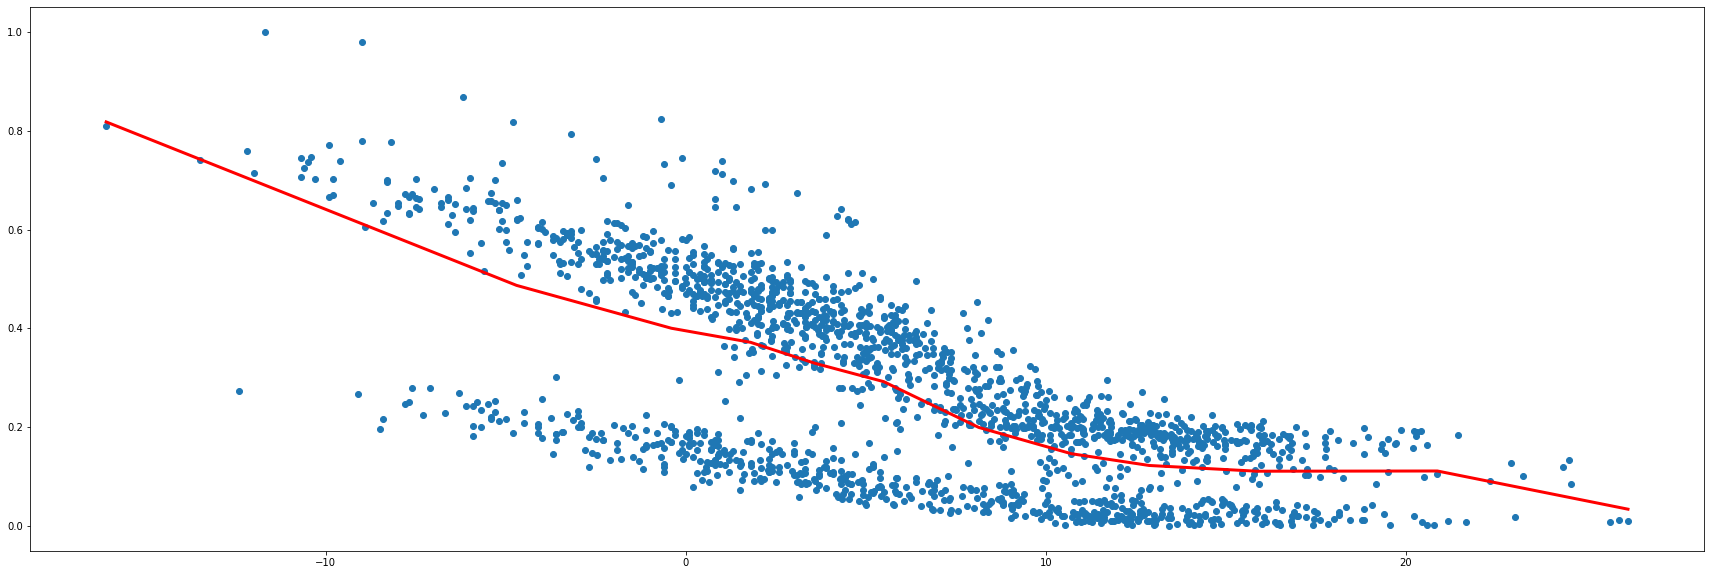

Trondheim Kommune - Nedre Flatåsen barnehage has mse of 0.018637730356329887 and is ranked 142 of 145


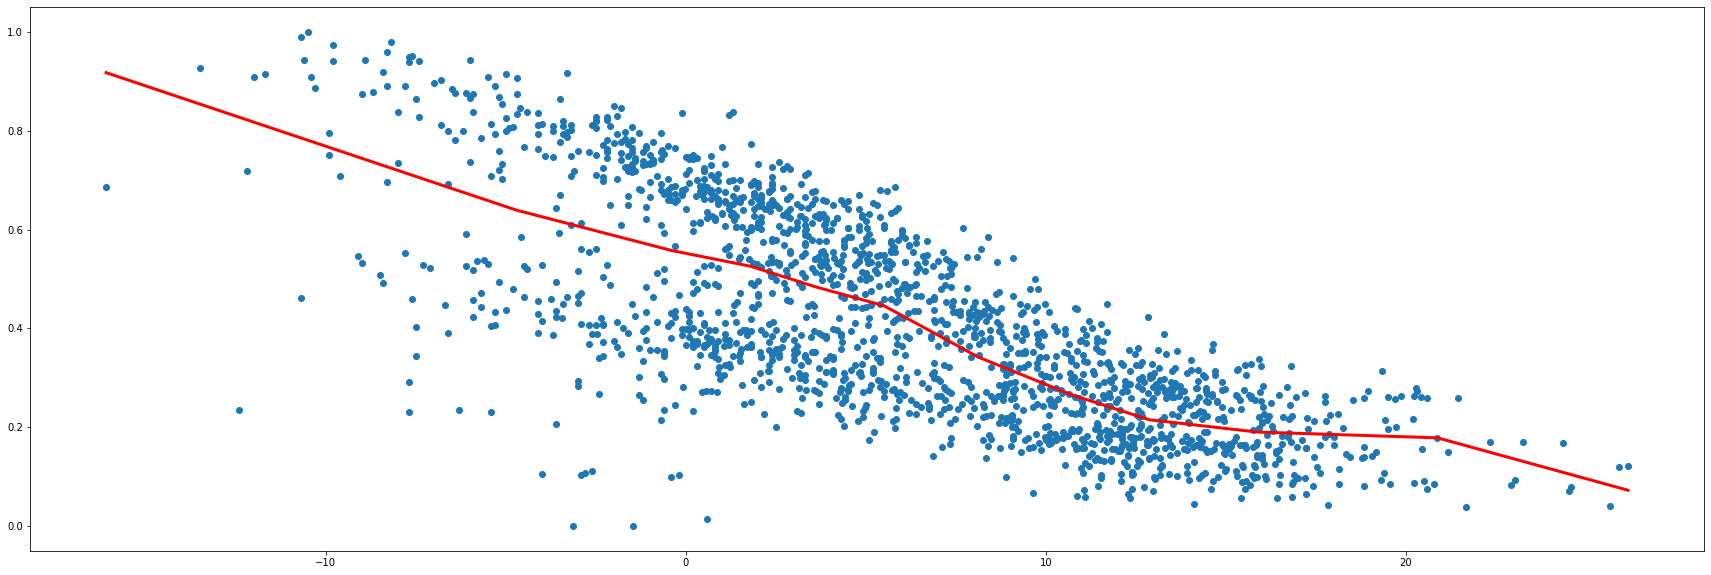

Trondheim Kommune - Romolslia barneskole has mse of 0.018382431560003413 and is ranked 141 of 145


In [37]:
# drop the buildings with larger than 0.02 mse
print(f'{len(building_et_results)} buildings before dropping')
building_et_results = [x for x in building_et_results if x[1] <= 0.02]
print(f'{len(building_et_results)} buildings after dropping')
# plot the bottom 5 after drop
for i in range(5):
    building_name, et_mse, et_model = building_et_results[-i-1]
    building_energy = building_dfs[building_name]['Totalt']
    et_model.plot(building_energy, daily_temp)
    print(f'{building_name} has mse of {et_mse} and is ranked {len(building_et_results) - i} of {len(building_et_results)}')

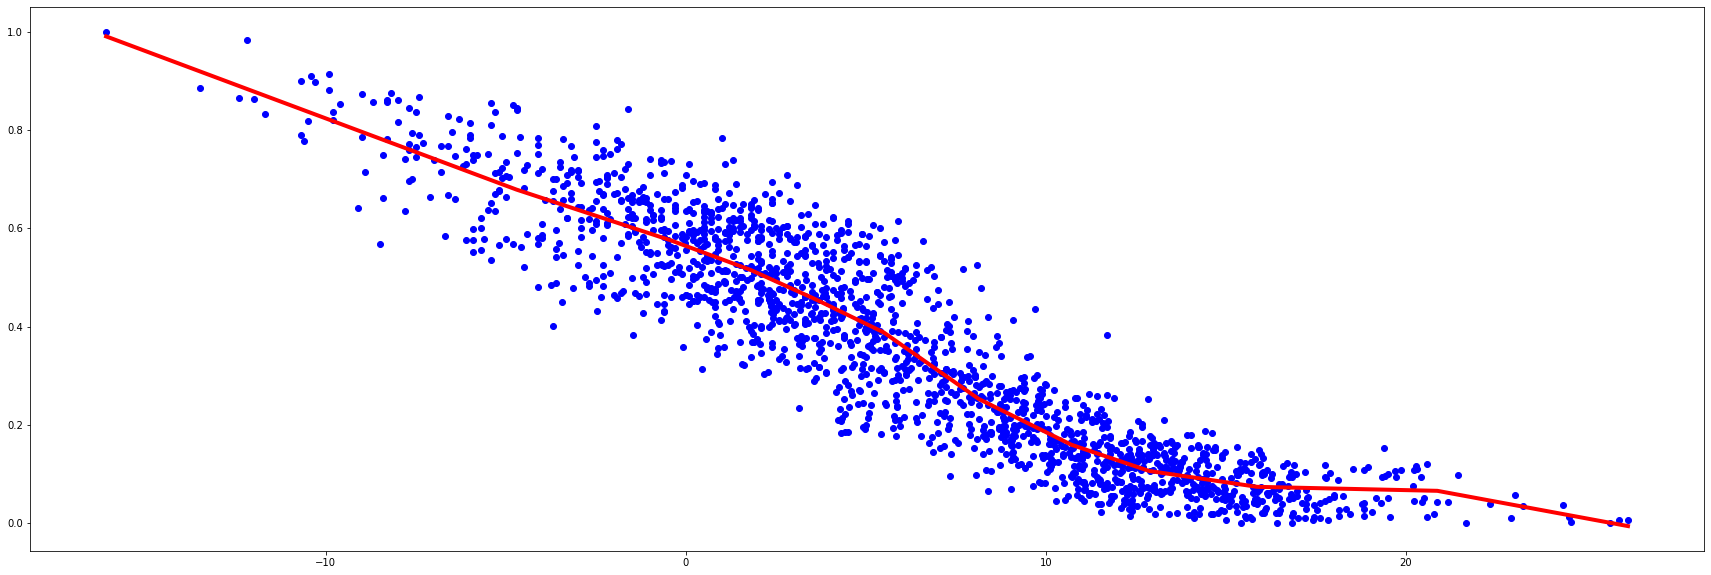

364 anomalies found


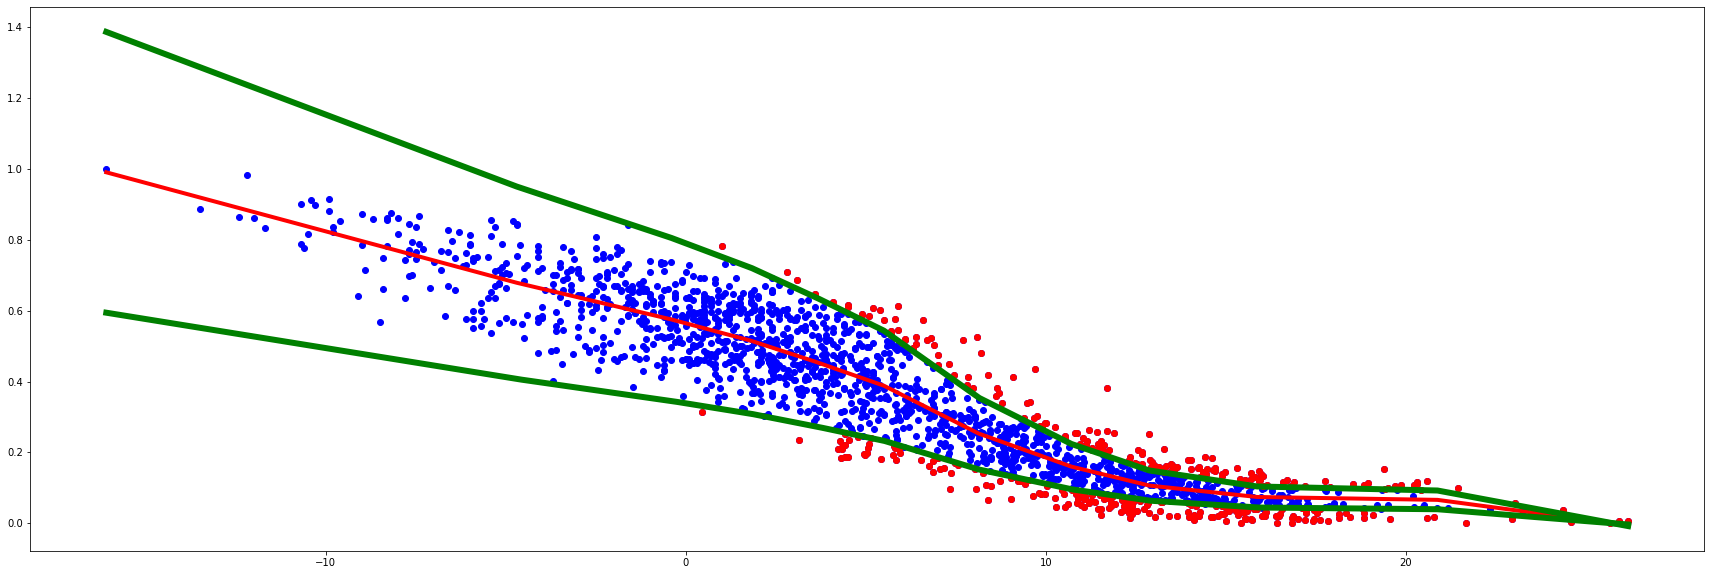

In [93]:
et_1 = model_1(test_energy, daily_temp, 200)
et_1.plot(test_energy, daily_temp)
# find anomalies with a manual threshold
anomalies = et_1.get_anomolies_series(test_energy, daily_temp, 0.4)
print(f'{len(anomalies)} anomalies found')
# color the anomalies red in the same temperature energy plot
et_1.plot(test_energy, daily_temp, threshold=0.4)